# Time-Series Forecasting

In simple terms data points that are collected sequentially at a regular interval with association over a time period is termed as time-series data. A time-series data having the mean and variance as constant is called stationary time-series. 
Time-series tend to have a linear relationship between lagged variables and this is called as autocorrelation. Hence a time-series historic data can be modelled to forecast the future data points without involvement of any other independent variables, these types of models are generally known as time-series forecasting. To name some key areas of applications of time-series are sales forecasting, economic forecasting, stock market forecasting etc. 

Autoregressive Integrated Moving Average (ARIMA)
Regression of the variable against itsefl. 

Note that this data set has a strong seasonal and trend component, but not so much of a cycle: pattern over multiple seasons.


In [1]:
import warnings
warnings.filterwarnings('ignore')


# Autoregressive Integrated Moving Average (ARIMA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.stattools import adfuller

# function to calculate MAE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

Let's predict sales data using ARIMA

In [4]:
# Data Source: O.D. Anderson (1976), in file: data/anderson14, Description: Monthly sales of company X Jan ’65 – May ’71 C. Cahtfield        
df = pd.read_csv('data/Timeseries.csv')
ts = pd.Series(list(df['Sales']), index=pd.to_datetime(df['Month'],format='%Y-%m'))

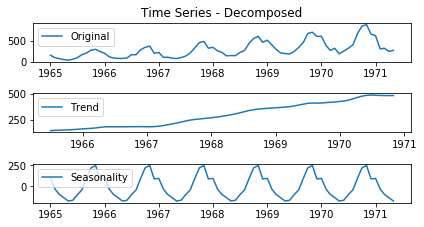

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.title('Time Series - Decomposed')
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()

# Checking for stationarity

Let's split the data into train and test. Since its a time series let's consider 1965 to 1968 for training and reamining for testing. 

Business forecasting edition by Hanke and Wichern recommend a minimum of 4 years of data depending on the regularity of data. If the seasonal pattern is regular 3 year data would be sufficient. 

In [11]:
s_test = adfuller(ts, autolag='AIC')
# extract p value from test results
print("p value > 0.05 means data is non-stationary: ", s_test[1])

p value > 0.05 means data is non-stationary:  0.988889420517


### Remove stationarity

In [12]:
# log transform to remove variability
ts_log = np.log(ts)
ts_log.dropna(inplace=True)

s_test = adfuller(ts_log, autolag='AIC')
print("Log transform stationary check p value: ", s_test[1])

Log transform stationary check p value:  0.785310212485


In [13]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

s_test = adfuller(ts_log_diff, autolag='AIC')
print("First order difference stationary check p value: ", s_test[1])

First order difference stationary check p value:  0.0240253928399


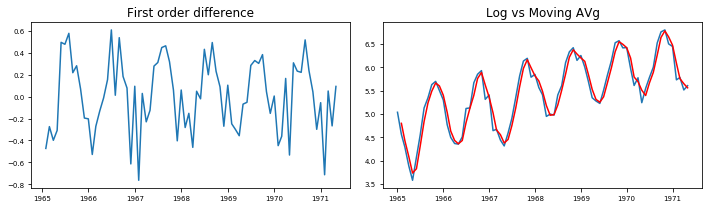

In [14]:
# moving average smoothens the line
moving_avg = pd.rolling_mean(ts_log,2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
ax1.set_title('First order difference')
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
ax1.plot(ts_log_diff)

ax2.plot(ts_log)
ax2.set_title('Log vs Moving AVg')
ax2.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax2.plot(moving_avg, color='red')
plt.tight_layout()

### Autocorrelation test

We determined that the log of time series requires at least one order differening to stationarize. Now lets plot ACV and PACF charts for first order log series

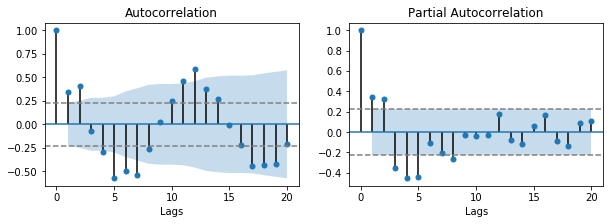

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))

# ACF chart
fig = sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=20, ax=ax1)

# draw 95% confidence interval line
ax1.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.set_xlabel('Lags')

# PACF chart
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=20, ax=ax2)

# draw 95% confidence interval line
ax2.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.set_xlabel('Lags')

PACF plot has a significant spike only at lag 1, meaning that all the higher-order autocorrelations are effectively explained by the lag-1 and lag-2 autocorrelation.

p = 2 i.e., the lag value where the PACF chart crosses the upper confidence interval for the first time

q = 2 i.e., the lag value where the ACF chart crosses the upper confidence interval for the first time

In [25]:
# build model
model = sm.tsa.ARIMA(ts_log, order=(2,0,2))
results_ARIMA = model.fit(disp=-1) 

ts_predict = results_ARIMA.predict()

# Evaluate model
print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic)

print("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values, ts_predict.values))) 

# check autocorrelation
print("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

AIC:  7.852110538087317
BIC:  21.9149430692
Mean Absolute Error:  0.195966054555
Root Mean Squared Error:  0.239792187868
Durbin-Watson statistic : 1.86457751445


Usual practice is to build several models with different p and q and select the one with smallest value of AIC, BIC, MAE and RMSE. 

Now lets' increase p to 3 and see if there is any difference in result.

/Users/nicapotato/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC:  -7.786304738132657
BIC:  8.62033321484
Mean Absolute Error:  0.167248393086
Root Mean Squared Error:  0.216165760461
Durbin-Watson statistic : 2.51835910767


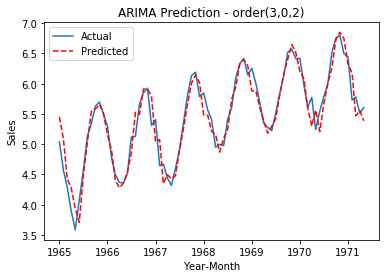

In [20]:
model = sm.tsa.ARIMA(ts_log, order=(3,0,2))
results_ARIMA = model.fit(disp=-1) 

ts_predict = results_ARIMA.predict()
plt.title('ARIMA Prediction - order(3,0,2)')
plt.plot(ts_log, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.legend(loc='best')

print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic)

print("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values, ts_predict.values)))

# check autocorrelation
print("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

### Let's try with one level differencing

/Users/nicapotato/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC:  -35.41898773394914
BIC:  -19.1038543519
Mean Absolute Error:  0.138765575849
Root Mean Squared Error:  0.183102456267
Durbin-Watson statistic : 1.94115825824


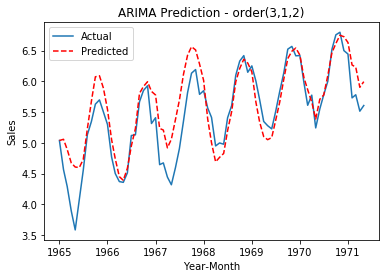

In [21]:
model = sm.tsa.ARIMA(ts_log, order=(3,1,2))
results_ARIMA = model.fit(disp=-1) 

ts_predict = results_ARIMA.predict()

# Correctcion for difference 
predictions_ARIMA_diff = pd.Series(ts_predict, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

plt.title('ARIMA Prediction - order(3,1,2)')
plt.plot(ts_log, label='Actual')
plt.plot(predictions_ARIMA_log, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.legend(loc='best')

print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic)

print("Mean Absolute Error: ", mean_absolute_error(ts_log_diff.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log_diff.values, ts_predict.values))) 
# check autocorrelation
print("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

In the above chart we can see that the model is over predicting at some places and AIC and BIC values is higher than previous model. Note: AIC/BIC can be positive or negative, however we should look at the absolute value of it for evaluation

### Predicting the future values

Below values (p=3, d=0, q=2) is giving the smaller number for evaluation matrics, so lets use this as final model to predict the future values i.e., for the year 1972

ARIMA (p, d, q) model
These are the key parameters of ARIMA and picking the right value for p, d, q will yield better model results.
- p = order of the autoregressive part. That is the number of unknown terms that multiply your signal at past times (so many past times as your value p).
- d = degree of first differencing involved. Number of times you have to difference your time series to have a stationary one.
- q = order of the moving average part. That is the number of unknown terms that multiply your forecast errors at past times (so many past times as your value q)

/Users/nicapotato/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


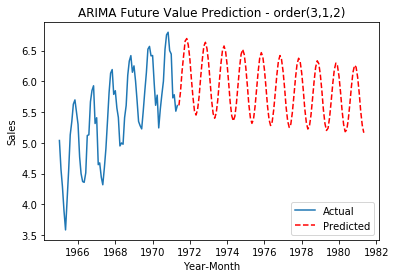

In [46]:
# final model
model = sm.tsa.ARIMA(ts_log, order=(5,0,5))
results_ARIMA = model.fit(disp=-1) 

# predict future values
ts_predict = results_ARIMA.predict('1971-06-01', '1981-05-01')
plt.title('ARIMA Future Value Prediction - order(3,1,2)')
plt.plot(ts_log, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.legend(loc='best')